In [1]:
import os 
import numpy as np
import pandas as pd
from tqdm import tqdm

import geopandas as gpd
import rasterio as rio
from shapely.geometry import Point
from shapely.geometry import Polygon

from geog import propagate

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

import contextily as cx

In [2]:
PROJ_CRS = 3857

In [3]:
def get_poly_tile(row):
    x, y = row['geometry'].x, row['geometry'].y
    offset = 1 / 240  # 0.004166666666666667
    L = [(x+offset,y+offset), (x-offset,y+offset), (x-offset,y-offset), (x+offset,y-offset), (x+offset,y+offset)]
    return Polygon(L)

In [4]:
def get_graph_edges(cur_city):
    coords_gdf = gpd.read_file(f'../data/city_pop_tiles/{cur_city}_coords.gpkg')
    city_center = coords_gdf[coords_gdf['is_center']].geometry.iloc[0]
    
    p = [city_center.x, city_center.y]
    n_points = 5
    d = 50000 # meters
    angles = np.linspace(0, 360, n_points)
    edge_points = propagate(p, angles, d)[:-1]  # Order is: E, N, W, S
    
    edge_points = [Point((point[0], point[1])) for point in edge_points]
    edge_points = gpd.GeoSeries(edge_points, crs=4326).to_crs(PROJ_CRS).to_list()

    return edge_points

In [5]:
def load_layers(cur_city):
    coords_gdf = gpd.read_file(f'../data/city_pop_tiles/{cur_city}_coords.gpkg')
    coords_gdf['geometry'] = coords_gdf.apply(lambda x: get_poly_tile(x), axis=1)
    coords_gdf = coords_gdf.to_crs(PROJ_CRS)

    rails_gdf = gpd.read_file(f'../data/osm_data/{cur_city}_rail_osm.geojson')
    rails_gdf = rails_gdf.to_crs(PROJ_CRS)

    stations_gdf = gpd.read_file(f'../data/osm_data/{cur_city}_station_osm.geojson')
    stations_gdf = stations_gdf.to_crs(PROJ_CRS)

    water_gdf = gpd.read_file(f'../data/city_water/{cur_city}_water.gpkg')
    water_gdf = water_gdf.to_crs(PROJ_CRS)

    return coords_gdf, rails_gdf, stations_gdf, water_gdf

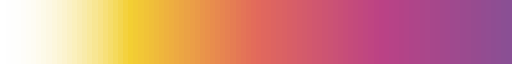

In [6]:

# # Original Colours
# colours = ['#ffffff', '#f1c500', '#dc4633']
# colors = np.array([(255, 255, 255, 0.5), (241, 197, 0, 1), (220, 70, 51, 1)]) / 255
# colour_map = LinearSegmentedColormap.from_list("soc", colours, N=100)  # https://matplotlib.org/stable/gallery/color/custom_cmap.html
# colour_map

colours = [
    (255 / 255, 255 / 255, 255 / 255,0),
	(241 / 255, 197 / 255, 0 / 255,0.8),
	(220 / 255, 70 / 255, 51 / 255,0.8),
	(171 / 255, 19 / 255, 104 / 255,0.8),
	(109 / 255, 36 / 255, 122 / 255,0.8),
]

colour_map = LinearSegmentedColormap.from_list("soc", colours, N=100)
colour_map

In [ ]:
cities_dens_gdf = gpd.read_file('../data/city_metrics.gpkg')

for i, row_i in tqdm(cities_dens_gdf.iterrows(), total=cities_dens_gdf.shape[0]):
    cur_city = row_i['NAME'].lower()

    f_out = f'../src/assets/city_image/{cur_city}.png'
    if os.path.exists(f_out):
        continue

    try:
        
        # Load information
        coords_gdf, rails_gdf, stations_gdf, water_gdf = load_layers(cur_city)
        edge_points = get_graph_edges(cur_city)
    
        # Make and save graph
        fig, ax = plt.subplots(figsize=(5, 5), dpi=250)
        adjust = 0.01  # higher means more zoom
        plt.subplots_adjust(left=-adjust, right=1 + adjust, bottom=-adjust, top=1 + adjust)

        base = coords_gdf.plot(
            ax=ax,
            column="pop_dens",
            cmap=colour_map,
            missing_kwds={'color': 'white'},
            vmin=0,
            vmax=30000,
        );

        cx.add_basemap(
            ax,
            source="https://services.arcgisonline.com/arcgis/rest/services/Elevation/World_Hillshade/MapServer/tile/{z}/{y}/{x}",
            crs=coords_gdf.crs.to_string(),
            alpha=0.55,
        )
        
        base = water_gdf.plot(ax=base, color='#c6e0ea');
        base = rails_gdf.plot(ax=base, color='#1e3765', lw=0.35, markersize=0.75);  # TODO: Filter for lines
        base = stations_gdf.plot(ax=base, marker='s', color='#1e3765', markersize=0.5);
        
        # edge_points is in the order [E, N, W, S]
        ax.set_xlim(edge_points[2].x, edge_points[0].x)  # W <--> E
        ax.set_ylim(edge_points[3].y, edge_points[1].y)  # S <--> N
        ax.margins(0,0)
        
        ax.set_axis_off();
    
        plt.savefig(f_out)
        # plt.savefig(f'../data/city_maps/{cur_city}.png')
        plt.clf()
        plt.close()
            
            # Clip circle: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_clip_path.html
            # but also can just do HTML/CSS circle!!
    except:
        print(f'failed on: {cur_city}')

  0%|          | 0/250 [00:00<?, ?it/s]Skipping field nodes: unsupported OGR type: 13
Skipping field nodes: unsupported OGR type: 13
  0%|          | 1/250 [00:04<19:01,  4.58s/it]Skipping field nodes: unsupported OGR type: 13
Skipping field nodes: unsupported OGR type: 13
  1%|          | 2/250 [00:08<18:10,  4.40s/it]Skipping field nodes: unsupported OGR type: 13
Skipping field nodes: unsupported OGR type: 13
  1%|          | 3/250 [00:12<17:26,  4.24s/it]Skipping field nodes: unsupported OGR type: 13
Skipping field nodes: unsupported OGR type: 13
  2%|▏         | 4/250 [00:15<14:10,  3.46s/it]Skipping field nodes: unsupported OGR type: 13
Skipping field nodes: unsupported OGR type: 13
  2%|▏         | 5/250 [00:18<14:17,  3.50s/it]Skipping field nodes: unsupported OGR type: 13
Skipping field nodes: unsupported OGR type: 13
  2%|▏         | 6/250 [00:21<13:35,  3.34s/it]Skipping field nodes: unsupported OGR type: 13
Skipping field nodes: unsupported OGR type: 13
  3%|▎         | 7/25